<a href="https://colab.research.google.com/github/syedshubha/PulseSCQ/blob/main/PulseQPT_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet qutip qutip-qip qiskit qiskit-aer pylatexenc &> /dev/null

In [2]:
import qutip as qt
from qutip import Qobj
from qiskit import QuantumCircuit, QuantumRegister
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import *
from qiskit.quantum_info import Operator, process_fidelity, Choi, Operator, DensityMatrix, Kraus, SuperOp, Pauli


import numpy as np
from scipy.linalg import polar, logm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

#No Pulse Attack

In [3]:
theta_vals = np.linspace(0, np.pi, 100)

theory = []
for theta in theta_vals:
    # Prepare input state: cos(θ)|0⟩ + sin(θ)|1⟩
    state_init = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()

    # Projector onto |1⟩
    P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()

    # Probability of measuring |1⟩
    prob_1 = qt.expect(P_1, state_init)
    theory.append(prob_1)

In [4]:
def plotting(theta, fun1, fun2=None):
  plt.figure(figsize=(8, 5))
  if fun2 is None:
    A= "No Attack"
  else:
    A = "pulse attack"
    plt.plot(theta / np.pi, fun2, label='No Attack', color='blue')
  plt.plot(theta / np.pi, fun1, label=A, color='red')
  plt.xlabel(r"Input State Rotation Angle $\theta/\pi$")
  plt.ylabel(r'Probability of measuring $|1\rangle$')
  plt.title(r'$\langle 1 | \psi_\theta \rangle^2$ vs $\theta$')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

# Pulse Attack

In [5]:
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
I = qt.qeye(2)

paulis = [I, sx, sy, sz]
pauli_labels = ['I', 'X', 'Y', 'Z']

In [6]:
def build_adam_state(theta):
    psi_theta = (np.cos(theta) * qt.basis(2, 0) + np.sin(theta) * qt.basis(2, 1)).unit()
    zero = qt.basis(2, 0)
    return qt.tensor(zero, zero, psi_theta)

In [7]:
def pulse_shape(shape="cos", A=1.0, delta=0.0, sigma=0.1, alpha=0.5, chirp_rate=0.0):

    if shape == "cos":
        return lambda t, args: A * np.cos(delta * t)

    elif shape == "gaussian":
        return lambda t, args: A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

    elif shape == "square":
        return lambda t, args: A if 0.3 <= t <= 0.7 else 0.0

    elif shape == "chirp":
        return lambda t, args: A * np.cos((delta + chirp_rate * t) * t)

    elif shape == "drag":
        return lambda t, args: A * (np.exp(-((t - 0.5)**2)/(2 * sigma**2))
                                   - alpha * (t - 0.5) / sigma**2 * np.exp(-((t - 0.5)**2)/(2 * sigma**2)))

    else:
        raise ValueError(f"Unknown pulse shape: {shape}")


In [8]:
def apply_eve_multi_attack(state_pre, J12=0.1, J01=0.1, A=(1.0, 1.0),
                            delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmax(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    A0, A1 = A
    delta0, delta1 = delta
    s1_12, s2_12 = coup_12
    s0_01, s1_01 = coup_01
    shape0, shape1 = shape
    kwargs0, kwargs1 = extra_params

    I = qt.qeye(2)

    # Coupling terms
    H_couple_12 = J12 * qt.tensor(I, s1_12, s2_12)
    H_couple_01 = J01 * qt.tensor(s0_01, s1_01, I)

    # Time-dependent drive terms
    coeff0 = pulse_shape(shape=shape0, A=A0, delta=delta0, **kwargs0)
    coeff1 = pulse_shape(shape=shape1, A=A1, delta=delta1, **kwargs1)

    H_p0 = [qt.tensor(qt.sigmax(), I, I), coeff0]
    H_p1 = [qt.tensor(I, qt.sigmax(), I), coeff1]

    H = [H_couple_12, H_couple_01, H_p0, H_p1]

    t_attack = np.linspace(0, 1.0, 50)
    sol = qt.mesolve(H, state_pre, t_attack, [], [])
    return sol.states[-1]


In [9]:
def measure_with_eve(theta_vals, J12=0.1, J01=0.1, A=(1.0, 1.0),
                     delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                     coup_01=(qt.sigmax(), qt.sigmax()),
                     shape=("cos", "cos"), extra_params=({}, {})):
    probs_attack = []
    for theta in theta_vals:
        state_init = build_adam_state(theta)
        state_post = apply_eve_multi_attack(
            state_init,
            J12=J12, J01=J01,
            A=A, delta=delta,
            coup_12=coup_12, coup_01=coup_01,
            shape=shape, extra_params=extra_params
        )
        state_q2 = state_post.ptrace(2)
        P_1 = qt.basis(2, 1) * qt.basis(2, 1).dag()
        prob_1 = qt.expect(P_1, state_q2)
        probs_attack.append(prob_1)
    return probs_attack

# Quantum Process Tomography

In [10]:
def prepare_input_states():
    return [
        qt.basis(2, 0),  # |0⟩
        qt.basis(2, 1),  # |1⟩
        (qt.basis(2, 0) + qt.basis(2, 1)).unit(),  # |+⟩
        (qt.basis(2, 0) + 1j * qt.basis(2, 1)).unit()  # |+i⟩
    ]

In [11]:
def apply_eve_process_on_q2(input_state,
                            J12=0.1, J01=0.1,
                            A=(1.0, 1.0),
                            delta=(0.0, 0.0),
                            coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmax(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    full_state = qt.tensor(qt.basis(2, 0), qt.basis(2, 0), input_state)
    final_state = apply_eve_multi_attack(
        state_pre=full_state,
        J12=J12,
        J01=J01,
        A=A,
        delta=delta,
        coup_12=coup_12,
        coup_01=coup_01,
        shape=shape,
        extra_params=extra_params
    )
    return final_state.ptrace(2)

In [12]:
def perform_qpt(J12=0.2, J01=0.1, A=(1.0, 1.0), delta=(0.0, 0.0),
                coup_12=(qt.sigmaz(), qt.sigmax()), coup_01=(qt.sigmax(), qt.sigmax()),
                shape=("cos", "cos"), extra_params=({}, {})):

    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    labels = ["I", "X", "Y", "Z"]
    N = len(paulis)
    chi = np.zeros((N, N), dtype=complex)

    input_states = prepare_input_states()
    output_states = [
        apply_eve_process_on_q2(psi,
                                J12=J12, J01=J01, A=A,
                                delta=delta,
                                coup_12=coup_12, coup_01=coup_01,
                                shape=shape,
                                extra_params=extra_params)
        for psi in input_states
    ]

    for m, Em in enumerate(paulis):
        for n, En in enumerate(paulis):
            acc = 0.0
            for i, psi_in in enumerate(input_states):
                rho_in = psi_in * psi_in.dag()
                term = (Em * rho_in * En.dag())
                acc += (term * output_states[i]).tr()
            chi[m, n] = acc / 2.0  # normalization

    return qt.Qobj(chi), labels


In [13]:
def plot_chi_matrix(chi_matrix, title='Chi Matrix'):
    fig, ax = plt.subplots(figsize=(6, 5))
    cax = ax.matshow(np.abs(chi_matrix), cmap='viridis')
    fig.colorbar(cax)
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))
    ax.set_xticklabels(pauli_labels)
    ax.set_yticklabels(pauli_labels)
    plt.title(title)
    plt.xlabel('n')
    plt.ylabel('m')
    plt.tight_layout()
    plt.show()

In [14]:
chi, label = perform_qpt(
    J12=0.2,
    J01=0.1,
    A=(1.0, 0.5),
    delta=(0.0, 0.0),
    coup_12=(qt.sigmaz(), qt.sigmax()),
    coup_01=(qt.sigmay(), qt.sigmax()),
    shape=("cos", "chirp"),
    extra_params=({}, {"chirp_rate": 5.0})
)

from qiskit.visualization import array_to_latex as show

/usr/local/lib/python3.11/dist-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [15]:
# Extract Kraus operators from the chi matrix
def kraus_operators_from_chi(chi):
    eigvals, eigvecs = np.linalg.eigh(chi)
    kraus_ops = []
    for i in range(len(eigvals)):
        if np.abs(eigvals[i]) > 1e-6:
            kraus_matrix = sum(
                eigvecs[j, i] * paulis[j] for j in range(4)
            )
            kraus_ops.append(np.sqrt(eigvals[i]) * kraus_matrix)
    return kraus_ops
kraus_ops = kraus_operators_from_chi(chi.full())

#Choi

In [16]:
def chi_to_superop(chi):
    superop = 0
    for m, Em in enumerate(paulis):
        for n, En in enumerate(paulis):
            kron = qt.tensor(Em, En.conj())
            superop += chi[m, n] * kron
    return Qobj(superop)

chi_identity = np.zeros((4, 4), dtype=complex)
chi_identity[0, 0] = 1.0  # Identity channel

#K=U.P (polar decomposition)

In [17]:
def U_theta(theta):
    return ry(theta)

def build_theoretical_kraus(theta):
    return [
        (1/2) * qt.qeye(2),
        (1/2) * U_theta(-theta) * qt.sigmax() * U_theta(theta),
        (1/2) * qt.sigmax(),
        (1/2) * U_theta(-theta) * qt.sigmax() * U_theta(theta) * qt.sigmax()
    ]

polar_U = []
polar_P = []
for K in kraus_ops:
    U, P = polar(K.full())
    polar_U.append(U)
    polar_P.append(P)

In [18]:
def fit_isometry(theoretical_kraus):
    def isometry_loss(flat_u):
        U_iso = flat_u.reshape((4,4))
        transformed_kraus = [
            sum(U_iso[i, j] * polar_U[j] @ polar_P[j] for j in range(4))
            for i in range(4)
        ]
        loss = sum(np.linalg.norm(transformed_kraus[i] - theoretical_kraus[i].full())**2
                   for i in range(4))
        return loss

    # Explicit constraint: U_iso @ U_iso† == I
    def unitary_constraint(flat_u):
        U_iso = flat_u.reshape((4,4))
        return np.linalg.norm(U_iso @ U_iso.conj().T - np.eye(4))

    init_guess = np.eye(4).flatten()
    constraints = [{
        'type': 'eq',
        'fun': unitary_constraint
    }]

    result = minimize(isometry_loss, init_guess, method='SLSQP', constraints=constraints, options={'ftol': 1e-8, 'maxiter': 1000})

    final_loss = isometry_loss(result.x)
    return final_loss, result.x.reshape((4,4)), unitary_constraint(result.x)


In [19]:
# ---- SWEEP θ ----
theta_vals = np.linspace(0, 2*np.pi, 100)
losses = []
thetas = []
unitary_errors = []
for theta in theta_vals:
    theoretical_kraus = build_theoretical_kraus(theta)
    loss, U_isometry, unitarity_err = fit_isometry(theoretical_kraus)
    losses.append(loss)
    thetas.append(theta)
    unitary_errors.append(unitarity_err)

In [20]:
# Find best θ
best_idx = np.argmin(losses)
best_theta = thetas[best_idx]
best_loss = losses[best_idx]
best_unitary_err = unitary_errors[best_idx]

print(f"Best fit θ (rad): {best_theta}")
print(f"Minimum Loss: {best_loss:.4e}")
print(f"Unitarity Error: {best_unitary_err:.4e}")

Best fit θ (rad): 4.0618571682777125
Minimum Loss: 4.3588e+00
Unitarity Error: 5.6136e-06


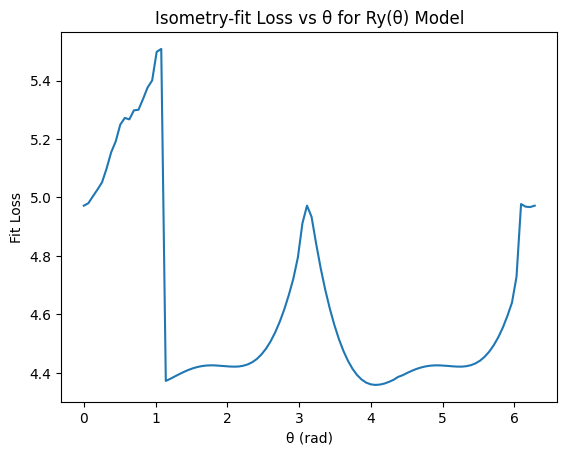

In [21]:
# Losses vs theta
import matplotlib.pyplot as plt
plt.plot(thetas, losses)
plt.xlabel("θ (rad)")
plt.ylabel("Fit Loss")
plt.title("Isometry-fit Loss vs θ for Ry(θ) Model")
plt.show()